# Libraries

In [1]:
import pandas as pd
import numpy as np
import re

# DATA PREPARATION

## 1) Lecture brute

In [3]:
# Paramètres
DATA_PATH = "../dataset/all_data.csv" 
TARGET_PRODUCTS = ["ThinkPad Laptop", "AAA Batteries (4-pack)"]
PERIOD = "MS"  # agrégation mensuelle: Month Start


df = pd.read_csv(
    DATA_PATH,
    dtype={"Order ID": "string", "Product": "string", "Quantity Ordered": "string",
           "Price Each": "string", "Order Date": "string", "Purchase Address": "string"},
    keep_default_na=False
)
df.head()

,Order ID,Product,Quantity Ordered,Price Each,Order Date,Purchase Address
0,176558,USB-C Charging Cable,2,11.95,04/19/19 08:46,"917 1st St, Dallas, TX 75001"
1,,,,,,
2,176559,Bose SoundSport Headphones,1,99.99,04/07/19 22:30,"682 Chestnut St, Boston, MA 02215"
3,176560,Google Phone,1,600,04/12/19 14:38,"669 Spruce St, Los Angeles, CA 90001"
4,176560,Wired Headphones,1,11.99,04/12/19 14:38,"669 Spruce St, Los Angeles, CA 90001"


In [4]:
len(df)

186850

## 2) Nettoyage de base

In [5]:
# Supprimer lignes entièrement vides
df = df.replace("", np.nan)
df = df.dropna(how="all").copy()
len(df)

186305

In [6]:
# Certaines lignes parasites ont "Order Date" dans la colonne (jeu Kaggle classique) -> filtrage
mask_bad = df["Order Date"].str.contains(r"Order Date", na=False)
df = df.loc[~mask_bad].copy()
len(df)

185950

In [7]:
# Typage
df["Quantity Ordered"] = pd.to_numeric(df["Quantity Ordered"], errors="coerce")
df["Price Each"] = pd.to_numeric(df["Price Each"], errors="coerce")
df["Order Date"] = pd.to_datetime(df["Order Date"], errors="coerce", format="%m/%d/%y %H:%M")
df.dtypes

Order ID            string[python]
Product             string[python]
Quantity Ordered             Int64
Price Each                 Float64
Order Date          datetime64[ns]
Purchase Address    string[python]
dtype: object

In [8]:
# Enlever lignes invalides post-coercition
df = df.dropna(subset=["Order Date", "Quantity Ordered", "Price Each", "Purchase Address"]).copy()
len(df)

185950

In [9]:
# 3) Extraction des composantes d'adresse: street, city, state, zip
# Format attendu: "917 1st St, Dallas, TX 75001"
addr = df["Purchase Address"].str.strip()

city_state_zip = addr.str.extract(r"^[^,]*,\s*(?P<city>[A-Za-z\s\.]+),\s*(?P<state>[A-Z]{2})\s*(?P<zip>\d{5})$")
df["city"] = city_state_zip["city"].str.strip()
df["state"] = city_state_zip["state"]
df["zip"] = city_state_zip["zip"]

In [10]:
# Clé géographique
df["city_state"] = df["city"].str.cat(df["state"].radd(" ("), na_rep="") + ")"
df["city_state"] = df["city_state"].str.replace(" ()", "", regex=False)  # sécurité

In [11]:
# 4) Features temporelles élémentaires
dt = df["Order Date"]
df["year"]  = dt.dt.year
df["month"] = dt.dt.month
df["weekofyear"] = dt.dt.isocalendar().week.astype(int)
df["dayofweek"] = dt.dt.dayofweek
df["hour"] = dt.dt.hour
df["period"] = dt.dt.to_period("M").dt.to_timestamp(how="start")  # début de mois

In [12]:
# 5) Ciblage produits et métriques élémentaires
df["revenue"] = df["Quantity Ordered"] * df["Price Each"]
df = df[df["Product"].isin(TARGET_PRODUCTS)].copy()

In [13]:
# Aperçu après préparation
df.head()

,Order ID,Product,Quantity Ordered,Price Each,Order Date,Purchase Address,city,state,zip,city_state,year,month,weekofyear,dayofweek,hour,period,revenue
20,176575,AAA Batteries (4-pack),1,2.99,2019-04-27 00:30:00,"433 Hill St, New York City, NY 10001",New York City,NY,10001,New York City (NY),2019,4,17,5,0,2019-04-01,2.99
28,176583,AAA Batteries (4-pack),2,2.99,2019-04-20 12:00:00,"146 Jackson St, Portland, OR 97035",Portland,OR,97035,Portland (OR),2019,4,16,5,12,2019-04-01,5.98
32,176586,AAA Batteries (4-pack),2,2.99,2019-04-10 17:00:00,"365 Center St, San Francisco, CA 94016",San Francisco,CA,94016,San Francisco (CA),2019,4,15,2,17,2019-04-01,5.98
45,176598,AAA Batteries (4-pack),2,2.99,2019-04-21 20:33:00,"294 Park St, San Francisco, CA 94016",San Francisco,CA,94016,San Francisco (CA),2019,4,16,6,20,2019-04-01,5.98
54,176607,AAA Batteries (4-pack),2,2.99,2019-04-18 12:11:00,"689 10th St, Boston, MA 02215",Boston,MA,02215,Boston (MA),2019,4,16,3,12,2019-04-01,5.98


In [14]:
# 6) Agrégation géospatiale × temps (mois)
agg = (
    df.groupby(["Product", "city_state", "period"], as_index=False)
      .agg(
          demand=("Quantity Ordered", "sum"),
          orders=("Order ID", "nunique"),
          avg_price=("Price Each", "mean"),
          revenue=("revenue", "sum")
      )
)
agg.head()

,Product,city_state,period,demand,orders,avg_price,revenue
0,AAA Batteries (4-pack),Atlanta (GA),2019-01-01,131,87,2.99,391.69
1,AAA Batteries (4-pack),Atlanta (GA),2019-02-01,152,105,2.99,454.48
2,AAA Batteries (4-pack),Atlanta (GA),2019-03-01,183,133,2.99,547.17
3,AAA Batteries (4-pack),Atlanta (GA),2019-04-01,239,161,2.99,714.61
4,AAA Batteries (4-pack),Atlanta (GA),2019-05-01,210,132,2.99,627.9


In [15]:
len(agg)

245

In [16]:
# 7) Compléter la grille temporelle
all_periods = pd.date_range(agg["period"].min(), agg["period"].max(), freq="MS")  # débuts de mois

keys = agg[["Product", "city_state"]].drop_duplicates()
full = (
    keys.assign(_k=1)
        .merge(pd.DataFrame({"period": all_periods, "_k": 1}), on="_k")
        .drop(columns="_k")
)

agg_full = (
    full.merge(agg, on=["Product","city_state","period"], how="left")
        .sort_values(["Product","city_state","period"])
        .reset_index(drop=True)
)

# 7b) Remplissages
for c in ["demand","orders","revenue"]:
    agg_full[c] = agg_full[c].fillna(0)


grp = agg_full.groupby(["Product","city_state"], sort=False)
agg_full["avg_price"] = grp["avg_price"].transform(lambda s: s.ffill().bfill())

In [17]:
# 8) Lags et moyennes mobiles
def add_ts_features(g):
    g = g.sort_values("period")
    g["lag1"] = g["demand"].shift(1)
    g["lag2"] = g["demand"].shift(2)
    g["ma3"]  = g["demand"].rolling(3, min_periods=1).mean().shift(1)
    g["ma6"]  = g["demand"].rolling(6, min_periods=1).mean().shift(1)
    m = g["period"].dt.month
    g["sin_month"] = np.sin(2*np.pi*m/12)
    g["cos_month"] = np.cos(2*np.pi*m/12)
    return g

feat = agg_full.groupby(["Product","city_state"], group_keys=False).apply(add_ts_features)
feat = feat.dropna(subset=["lag1","lag2"]).reset_index(drop=True)

C:\Users\tomix\AppData\Local\Temp\ipykernel_16652\3419090649.py:13: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  feat = agg_full.groupby(["Product","city_state"], group_keys=False).apply(add_ts_features)


In [18]:
# 9) Derniers contrôles et aperçu
feat.head(10)

,Product,city_state,period,demand,orders,avg_price,revenue,lag1,lag2,ma3,ma6,sin_month,cos_month
0,AAA Batteries (4-pack),Atlanta (GA),2019-03-01,183,133.0,2.99,547.17,152,131,141.500000,141.500000,1.000000e+00,6.123234e-17
1,AAA Batteries (4-pack),Atlanta (GA),2019-04-01,239,161.0,2.99,714.61,183,152,155.333333,155.333333,8.660254e-01,-5.000000e-01
2,AAA Batteries (4-pack),Atlanta (GA),2019-05-01,210,132.0,2.99,627.9,239,183,191.333333,176.250000,5.000000e-01,-8.660254e-01
3,AAA Batteries (4-pack),Atlanta (GA),2019-06-01,158,104.0,2.99,472.42,210,239,210.666667,183.000000,1.224647e-16,-1.000000e+00
4,AAA Batteries (4-pack),Atlanta (GA),2019-07-01,167,114.0,2.99,499.33,158,210,202.333333,178.833333,-5.000000e-01,-8.660254e-01
5,AAA Batteries (4-pack),Atlanta (GA),2019-08-01,164,113.0,2.99,490.36,167,158,178.333333,184.833333,-8.660254e-01,-5.000000e-01
6,AAA Batteries (4-pack),Atlanta (GA),2019-09-01,159,100.0,2.99,475.41,164,167,163.000000,186.833333,-1.000000e+00,-1.836970e-16
7,AAA Batteries (4-pack),Atlanta (GA),2019-10-01,254,172.0,2.99,759.46,159,164,163.333333,182.833333,-8.660254e-01,5.000000e-01
8,AAA Batteries (4-pack),Atlanta (GA),2019-11-01,217,155.0,2.99,648.83,254,159,192.333333,185.333333,-5.000000e-01,8.660254e-01
9,AAA Batteries (4-pack),Atlanta (GA),2019-12-01,325,221.0,2.99,971.75,217,254,210.000000,186.500000,-2.449294e-16,1.000000e+00


In [19]:
# 10) Tableau prêt pour modélisation
# Colonnes explicatives candidates
feature_cols = [
    "avg_price","lag1","lag2","ma3","ma6","sin_month","cos_month"
]
target_col = "demand"

X = feat[["Product","city_state","period"] + feature_cols].copy()
y = feat[target_col].astype(float).copy()

print("X shape:", X.shape, " y shape:", y.shape)
X.head()

X shape: (220, 10)  y shape: (220,)


,Product,city_state,period,avg_price,lag1,lag2,ma3,ma6,sin_month,cos_month
0,AAA Batteries (4-pack),Atlanta (GA),2019-03-01,2.99,152,131,141.500000,141.500000,1.000000e+00,6.123234e-17
1,AAA Batteries (4-pack),Atlanta (GA),2019-04-01,2.99,183,152,155.333333,155.333333,8.660254e-01,-5.000000e-01
2,AAA Batteries (4-pack),Atlanta (GA),2019-05-01,2.99,239,183,191.333333,176.250000,5.000000e-01,-8.660254e-01
3,AAA Batteries (4-pack),Atlanta (GA),2019-06-01,2.99,210,239,210.666667,183.000000,1.224647e-16,-1.000000e+00
4,AAA Batteries (4-pack),Atlanta (GA),2019-07-01,2.99,158,210,202.333333,178.833333,-5.000000e-01,-8.660254e-01


# MODELISATION

In [25]:
from pycaret.regression import setup, compare_models, tune_model, finalize_model, predict_model, pull

In [30]:
# 0) Paramètres
FEATURES = ["city_state","avg_price","lag1","lag2","ma3","ma6","sin_month","cos_month"]
NUM_FEATS = ["avg_price","lag1","lag2","ma3","ma6","sin_month","cos_month"]
CAT_FEATS = ["city_state"]
TARGET = "demand"
PRODUCTS = ["ThinkPad Laptop", "AAA Batteries (4-pack)"]

# 1) Sécurité: forward-fill du prix par (Product, city_state) ordonné sur period
feat = feat.sort_values(["Product","city_state","period"]).copy()
feat["avg_price"] = (
    feat.groupby(["Product","city_state"], sort=False)["avg_price"]
        .transform(lambda s: s.ffill())
)

# 2) Retirer lignes sans lags
feat = feat.dropna(subset=["lag1","lag2"]).reset_index(drop=True)

# 3) Choisir une coupure temporelle robuste: derniers ~20% des mois en test, min 2 mois
all_months = (
    feat["period"].drop_duplicates().sort_values().tolist()
)
n_months = len(all_months)
test_k = max(2, int(np.ceil(0.2 * n_months)))
cutoff = all_months[-(test_k+1)] if n_months > test_k else all_months[-2]

print(f"Split: train ≤ {cutoff.date()}  |  test > {cutoff.date()}  |  total mois={n_months}, test mois~{test_k}")

def train_test_split_ts(df, cutoff_ts):
    train = df[df["period"] <= cutoff_ts].copy()
    test  = df[df["period"]  > cutoff_ts].copy()
    # Imputation prix côté TRAIN uniquement, puis appliquer la moyenne produit du TRAIN aux NA du TEST
    prod_mean_price = train.groupby("Product")["avg_price"].mean().rename("avg_price_prod_mean")
    train = train.merge(prod_mean_price, on="Product", how="left")
    test  = test.merge(prod_mean_price, on="Product", how="left")
    for d in (train, test):
        d["avg_price"] = d["avg_price"].fillna(d["avg_price_prod_mean"])
        d.drop(columns=["avg_price_prod_mean"], inplace=True)
    return train, test

models = {}
reports = {}

for prod in PRODUCTS:
    # 4) Sous-ensemble produit et tri
    data = (
        feat[feat["Product"] == prod]
        .sort_values(["period","city_state"])
        .reset_index(drop=True)
    )

    # 5) Split temporel explicite
    train, test = train_test_split_ts(data, cutoff)

    # Garde-fous: s'assurer qu'on a bien un test non vide
    if test.empty or train.empty:
        print(f"[{prod}] Jeu de test vide. Augmentez la fenêtre test.")
        continue

    # 6) Setup PyCaret sur TRAIN uniquement
    setup(
        data=train[FEATURES + [TARGET]],
        target=TARGET,
        numeric_features=NUM_FEATS,
        categorical_features=CAT_FEATS,
        fold_strategy="timeseries",
        fold=5,
        data_split_shuffle=False,
        verbose=False,
        log_experiment=False,
        use_gpu=False,
        session_id=42,
    )

    # 7) Sélection + tuning + finalisation
    best  = compare_models(sort="MAE")
    tuned = tune_model(best, optimize="MAE")
    final = finalize_model(tuned)
    models[prod] = final

    # 8) Leaderboard (pour audit)
    reports[prod] = pull().copy()

    # 9) VRAI holdout: prédire sur TEST
    preds = predict_model(final, data=test[FEATURES].copy())
    pred_col = "prediction_label" if "prediction_label" in preds.columns else "Label"
    test_mae = (preds[pred_col].to_numpy() - test[TARGET].to_numpy()).astype(float)
    test_mae = np.abs(test_mae).mean()

    print(f"{prod} — TEST MAE: {test_mae:.3f} | n_train={len(train)} | n_test={len(test)}")

Split: train ≤ 2019-10-01  |  test > 2019-10-01  |  total mois=11, test mois~3


,Model,MAE,MSE,RMSE,R2,RMSLE,MAPE,TT (Sec)
gbr,Gradient Boosting Regressor,7.5524,106.7774,9.9406,0.6789,0.3352,0.3395,0.0200
et,Extra Trees Regressor,7.7409,103.6458,10.0327,0.6747,0.3604,0.3697,0.0280
rf,Random Forest Regressor,7.7624,101.6653,9.8992,0.6656,0.3310,0.3470,0.0380
ada,AdaBoost Regressor,7.8307,108.4552,10.2192,0.6256,0.3849,0.3989,0.0220
omp,Orthogonal Matching Pursuit,8.1507,109.4290,10.1238,0.6186,0.3493,0.3705,0.0140
en,Elastic Net,8.2565,121.5102,10.1319,0.5901,0.3202,0.3295,0.5340
catboost,CatBoost Regressor,8.2579,117.8542,10.6710,0.6503,0.3593,0.3785,0.2700
br,Bayesian Ridge,8.5829,129.9744,10.4530,0.5511,0.3264,0.3472,0.0140
knn,K Neighbors Regressor,9.1289,142.8071,11.3190,0.5741,0.3983,0.4465,0.0120
llar,Lasso Least Angle Regression,9.3969,152.8996,11.4362,0.5150,0.3336,0.3594,0.0160


,MAE,MSE,RMSE,R2,RMSLE,MAPE
Fold,,,,,,
0,8.7120,146.1410,12.0889,0.7738,0.4013,0.4112
1,11.5727,206.9209,14.3847,0.5416,0.2941,0.3122
2,8.3144,91.8788,9.5853,0.4517,0.4070,0.4801
3,5.5417,53.2368,7.2964,0.8772,0.3381,0.3380
4,8.8161,148.0185,12.1663,0.4858,0.3542,0.3565
Mean,8.5914,129.2392,11.1043,0.6260,0.3589,0.3796
Std,1.9147,52.6212,2.4358,0.1686,0.0419,0.0599


Fitting 5 folds for each of 10 candidates, totalling 50 fits
Original model was better than the tuned model, hence it will be returned. NOTE: The display metrics are for the tuned model (not the original one).


ThinkPad Laptop — TEST MAE: 23.634 | n_train=80 | n_test=30


,Model,MAE,MSE,RMSE,R2,RMSLE,MAPE,TT (Sec)
et,Extra Trees Regressor,51.7073,5256.0330,68.3822,0.5388,0.2449,0.2473,0.0320
br,Bayesian Ridge,53.2257,7282.7199,71.0065,0.6340,0.2414,0.2280,0.0140
gbr,Gradient Boosting Regressor,54.2722,5500.3321,68.4886,0.5036,0.2448,0.2529,0.0200
en,Elastic Net,56.6211,7874.5766,75.3055,0.6235,0.2510,0.2414,0.0140
ada,AdaBoost Regressor,56.7683,5652.3189,70.8260,0.4984,0.2513,0.2649,0.0220
omp,Orthogonal Matching Pursuit,56.9116,6886.3202,73.7163,0.4754,0.2511,0.2542,0.0140
llar,Lasso Least Angle Regression,57.9928,8129.3797,76.2614,0.6164,0.2561,0.2509,0.0140
lasso,Lasso Regression,58.3912,8188.7934,76.5956,0.6091,0.2594,0.2548,0.0140
rf,Random Forest Regressor,59.4371,6897.7364,77.8596,0.3826,0.3131,0.3174,0.0380
huber,Huber Regressor,59.6725,7959.5296,77.3448,0.6348,0.2586,0.2506,0.0160


,MAE,MSE,RMSE,R2,RMSLE,MAPE
Fold,,,,,,
0,71.6514,14678.0846,121.1531,0.6661,0.5656,0.5650
1,60.8256,4772.9986,69.0869,0.8519,0.4774,0.4897
2,105.8516,15289.7846,123.6519,-1.1574,0.4733,0.5688
3,26.7521,1145.5194,33.8455,0.9392,0.1567,0.1410
4,45.1587,2869.6746,53.5693,0.8567,0.2184,0.2180
Mean,62.0479,7751.2124,80.2614,0.4313,0.3783,0.3965
Std,26.6215,6019.0693,36.1846,0.7994,0.1604,0.1811


Fitting 5 folds for each of 10 candidates, totalling 50 fits
Original model was better than the tuned model, hence it will be returned. NOTE: The display metrics are for the tuned model (not the original one).


AAA Batteries (4-pack) — TEST MAE: 166.553 | n_train=80 | n_test=30


# PREDICTIONS POUR 2025

In [31]:
from pathlib import Path
from pycaret.regression import save_model, load_model, predict_model

In [32]:
MODELS_DIR = Path("../models")
OUTPUT_DIR = Path("../outputs")
MODELS_DIR.mkdir(parents=True, exist_ok=True)
OUTPUT_DIR.mkdir(parents=True, exist_ok=True)

FEATURES = ["city_state","avg_price","lag1","lag2","ma3","ma6","sin_month","cos_month"]
PRODUCTS = list(models.keys())

In [34]:
# == 1) Sauvegarde des modèles ==
def slug(s: str) -> str:
    return (
        s.lower()
         .replace(" ", "_")
         .replace("(", "")
         .replace(")", "")
         .replace("/", "_")
         .replace("-", "_")
    )

for prod, mdl in models.items():
    save_model(mdl, str(MODELS_DIR / f"reg_{slug(prod)}"))

Transformation Pipeline and Model Successfully Saved
Transformation Pipeline and Model Successfully Saved


In [35]:
# == 2) Rechargement des modèles (propre pour l'inférence) ==
loaded_models = {prod: load_model(str(MODELS_DIR / f"reg_{slug(prod)}")) for prod in PRODUCTS}


Transformation Pipeline and Model Successfully Loaded
Transformation Pipeline and Model Successfully Loaded


In [41]:
FEATURES = ["city_state","avg_price","lag1","lag2","ma3","ma6","sin_month","cos_month"]

# 1) Normalisation temps + prix par défaut
feat = feat.copy()
feat["period"] = pd.to_datetime(feat["period"]).dt.to_period("M").dt.to_timestamp(how="start")
prod_price_default = feat.groupby("Product")["avg_price"].mean().to_dict()
prod_demand_median  = feat.groupby("Product")["demand"].median().to_dict()
# profil saisonnier par produit (médiane par mois, sinon fallback médiane produit)
prod_seasonal = (
    feat.assign(month=lambda d: d["period"].dt.month)
        .groupby(["Product","month"])["demand"].median()
)

def seasonal_seed(product, month):
    # month = 1..12
    if (product, month) in prod_seasonal.index:
        return float(prod_seasonal.loc[(product, month)])
    return float(prod_demand_median.get(product, 0.0))

# 2) Forecast récursif du dernier mois réel -> déc 2025, puis on garde 2025
def forecast_to_2025_for_product(feat_df: pd.DataFrame, product: str, model) -> pd.DataFrame:
    dfp = feat_df[feat_df["Product"] == product].copy()
    if dfp.empty:
        return pd.DataFrame(columns=["Product","city_state","period","yhat","avg_price_used"])

    # dernier mois réellement observé pour ce produit
    last_real = dfp["period"].max()
    # si le dernier mois >= déc 2025, rien à faire
    end_2025 = pd.Timestamp("2025-12-01")
    if last_real >= end_2025:
        # déjà tout observé, retourne vide
        return pd.DataFrame(columns=["Product","city_state","period","yhat","avg_price_used"])

    # villes connues pour le produit
    cities = dfp["city_state"].dropna().drop_duplicates().tolist()
    out_rows = []

    # on va simuler mois par mois du mois suivant last_real jusqu'à déc 2025
    future_all = pd.date_range((last_real + pd.offsets.MonthBegin(1)).normalize(), end_2025, freq="MS")

    for cs in cities:
        hist = (
            dfp[(dfp["city_state"] == cs)]
            .sort_values("period")
        )
        # série réelle de demande pour semer
        y_hist = hist["demand"].astype(float).tolist()

        # prix: dernier connu pour cette ville, sinon prix moyen produit
        if not hist.empty and hist["avg_price"].notna().any():
            cur_price = float(hist["avg_price"].ffill().iloc[-1])
        else:
            cur_price = float(prod_price_default.get(product, np.nan))

        # init du buffer pour lags et MA
        if len(y_hist) >= 6:
            last_vals = y_hist[-6:]
        elif len(y_hist) > 0:
            # complète avec le profil saisonnier du mois du dernier point
            m_last = int(hist["period"].iloc[-1].month)
            seed = seasonal_seed(product, m_last)
            last_vals = ( [seed] * (6 - len(y_hist)) ) + y_hist
        else:
            # aucune donnée pour cette ville -> initialise avec 6 mois saisonniers
            # en remontant 6 mois avant le premier future
            start_m = int(future_all[0].month)
            months = [((start_m - i - 1) % 12) + 1 for i in range(6)][::-1]
            last_vals = [seasonal_seed(product, m) for m in months]

        # parcours récursif
        for ts in future_all:
            month = int(ts.month)
            sin_m = np.sin(2*np.pi*month/12.0)
            cos_m = np.cos(2*np.pi*month/12.0)

            lag1 = last_vals[-1]
            lag2 = last_vals[-2] if len(last_vals) >= 2 else last_vals[-1]
            ma3  = float(np.mean(last_vals[-3:])) if len(last_vals) else 0.0
            ma6  = float(np.mean(last_vals[-6:])) if len(last_vals) else 0.0

            rowX = pd.DataFrame([{
                "city_state": cs,
                "avg_price": cur_price,
                "lag1": lag1,
                "lag2": lag2,
                "ma3": ma3,
                "ma6": ma6,
                "sin_month": sin_m,
                "cos_month": cos_m
            }])

            pred_df = predict_model(model, data=rowX)
            pred_col = "prediction_label" if "prediction_label" in pred_df.columns else "Label"
            yhat = float(pred_df.iloc[0][pred_col])

            out_rows.append({
                "Product": product,
                "city_state": cs,
                "period": ts,
                "yhat": yhat,
                "avg_price_used": cur_price
            })

            # update des buffers
            last_vals.append(yhat)
            if len(last_vals) > 6:
                last_vals = last_vals[-6:]

    res = pd.DataFrame(out_rows).sort_values(["city_state","period"]).reset_index(drop=True)
    # on garde uniquement l’année 2025 pour le rendu
    res_2025 = res[res["period"].dt.year == 2025].reset_index(drop=True)
    return res_2025

In [42]:
# 3) Application à tous les produits + sauvegarde
predictions_2025 = {}
for prod, mdl in loaded_models.items():
    df_pred = forecast_to_2025_for_product(feat, prod, mdl)
    predictions_2025[prod] = df_pred
    print(prod, "— lignes 2025:", len(df_pred))
    display(df_pred.head())

ThinkPad Laptop — lignes 2025: 120


,Product,city_state,period,yhat,avg_price_used
0,ThinkPad Laptop,Atlanta (GA),2025-01-01,83.177470,999.99
1,ThinkPad Laptop,Atlanta (GA),2025-02-01,84.103629,999.99
2,ThinkPad Laptop,Atlanta (GA),2025-03-01,72.552090,999.99
3,ThinkPad Laptop,Atlanta (GA),2025-04-01,66.901539,999.99
4,ThinkPad Laptop,Atlanta (GA),2025-05-01,68.626248,999.99


AAA Batteries (4-pack) — lignes 2025: 120


,Product,city_state,period,yhat,avg_price_used
0,AAA Batteries (4-pack),Atlanta (GA),2025-01-01,436.19,2.99
1,AAA Batteries (4-pack),Atlanta (GA),2025-02-01,447.91,2.99
2,AAA Batteries (4-pack),Atlanta (GA),2025-03-01,387.33,2.99
3,AAA Batteries (4-pack),Atlanta (GA),2025-04-01,385.23,2.99
4,AAA Batteries (4-pack),Atlanta (GA),2025-05-01,377.12,2.99


In [49]:
# Sauvegarde csv

import csv
import pandas as pd
from pathlib import Path

OUTPUT_DIR = Path("../outputs")
OUTPUT_DIR.mkdir(parents=True, exist_ok=True)

def slug(s: str) -> str:
    return (s.lower().replace(" ", "_").replace("(", "").replace(")", "").replace("/", "_").replace("-", "_"))

def format_preds(dfp: pd.DataFrame) -> pd.DataFrame:
    out = (
        dfp.rename(columns={"yhat": "Predicted_demand", "city_state": "City_state"})
           [["Product", "City_state", "period", "Predicted_demand"]]
           .copy()
    )
    # period -> "YYYY-MM" en str
    out["period"] = pd.to_datetime(out["period"]).dt.to_period("M").astype(str)
    # types natifs python
    out["Product"] = out["Product"].astype(str)
    out["City_state"] = out["City_state"].astype(str)
    out["Predicted_demand"] = pd.to_numeric(out["Predicted_demand"], errors="coerce").astype(int)
    out = out.reset_index(drop=True)
    # colonnes str simples
    out.columns = ["Product", "City_state", "period", "Predicted_demand"]
    return out

def save_csv_compat(df: pd.DataFrame, path: Path):
    # Écrit sans passer par DataFrame.to_csv pour éviter _format_native_types
    with open(path, "w", newline="", encoding="utf-8") as f:
        w = csv.writer(f)
        w.writerow(list(df.columns))
        for row in df.itertuples(index=False, name=None):
            w.writerow(row)

# Sauvegarde par produit
for prod, dfp in predictions_2025.items():
    df_save = format_preds(dfp)
    save_csv_compat(df_save, OUTPUT_DIR / f"predictions_2025_{slug(prod)}.csv")

# Fichier combiné
all_2025 = pd.concat([format_preds(dfp) for dfp in predictions_2025.values()], ignore_index=True)
save_csv_compat(all_2025, OUTPUT_DIR / "predictions_2025_all_products.csv")

# DATA VISUALISATION - POUR 2025

In [52]:
import pandas as pd, csv
import pgeocode

_orig_to_csv = pd.DataFrame.to_csv
def _safe_to_csv(self, path_or_buf, *args, **kwargs):
    if isinstance(path_or_buf, str):
        enc = kwargs.get("encoding", "utf-8")
        with open(path_or_buf, "w", newline="", encoding=enc) as f:
            w = csv.writer(f)
            w.writerow(list(self.columns.map(str)))
            for row in self.itertuples(index=False, name=None):
                w.writerow(row)
        return
    return _orig_to_csv(self, path_or_buf, *args, **kwargs)

pd.DataFrame.to_csv = _safe_to_csv
nomi = pgeocode.Nominatim('us')  # téléchargement + cache
pd.DataFrame.to_csv = _orig_to_csv  # restauration

In [53]:
# 2) ZIP majoritaire par City_state -> lat/lon
zip_major = (
    df.dropna(subset=["zip","city_state"])
      .assign(zip=lambda d: d["zip"].astype(str).str[:5])
      .groupby("city_state")["zip"].agg(lambda s: s.value_counts().idxmax())
      .reset_index()
)

geo = zip_major.assign(
    lat=lambda d: d["zip"].apply(lambda z: nomi.query_postal_code(z).latitude),
    lon=lambda d: d["zip"].apply(lambda z: nomi.query_postal_code(z).longitude),
).dropna(subset=["lat","lon"]).reset_index(drop=True)

In [55]:
# 3) Agréger la demande 2025 par localisation pour chaque produit
def yearly_by_loc(df_pred_2025):
    tmp = (df_pred_2025.assign(yhat=lambda d: pd.to_numeric(d["yhat"], errors="coerce"))
           .groupby(["Product","city_state"], as_index=False)["yhat"].sum())
    return tmp.rename(columns={"yhat":"demand_2025"})

year_tables = {prod: yearly_by_loc(dfp) for prod, dfp in predictions_2025.items()}

In [88]:
# Heatmap 2025 en N&B: choisir base="light" (carto-positron) ou "dark" (carto-darkmatter)
import numpy as np
import plotly.express as px

def density_map_bw(
    prod, tab, geo,
    mode="linear", q_lo=0.05, q_hi=0.95,
    gamma=0.9, radius=45,
    base="light"  # "light" -> carto-positron (BW clair), "dark" -> carto-darkmatter (BW sombre), "plain" -> white-bg
):
    mdf = (tab.merge(geo, on="city_state", how="left")
             .dropna(subset=["lat","lon","demand_2025"])
             .reset_index(drop=True))
    if mdf.empty:
        print(f"[{prod}] aucune coordonnée."); return None

    z_raw = mdf["demand_2025"].astype(float).to_numpy()
    if mode == "log":
        z = np.log1p(z_raw); vmin, vmax = z.min(), z.max()
    elif mode == "robust":
        vmin, vmax = np.quantile(z_raw, q_lo), np.quantile(z_raw, q_hi)
        z = np.clip(z_raw, vmin, vmax)
    else:
        vmin, vmax = z_raw.min(), z_raw.max(); z = z_raw

    rng = (vmax - vmin) if vmax > vmin else 1.0
    zn = np.clip((z - vmin) / rng, 0, 1) ** gamma
    mdf["weight"] = zn

    style = {"light":"carto-positron", "dark":"carto-darkmatter", "plain":"white-bg"}[base]

    fig = px.density_mapbox(
        mdf, lat="lat", lon="lon", z="weight", radius=radius,
        center=dict(lat=mdf["lat"].mean(), lon=mdf["lon"].mean()),
        zoom=4, mapbox_style=style,
        hover_name="city_state",
        hover_data={"demand_2025": True, "lat": False, "lon": False, "weight": False},
        color_continuous_scale=["#2c7bb6","#abd9e9","#ffffbf","#fdae61","#d7191c"],
        range_color=(0,1), opacity=0.9
    )
    fig.update_layout(height=600, margin=dict(l=0,r=0,t=30,b=0),
                      title=f"Heatmap 2025 — {prod} | base={base} | vmin={vmin:.1f} vmax={vmax:.1f}")
    return fig


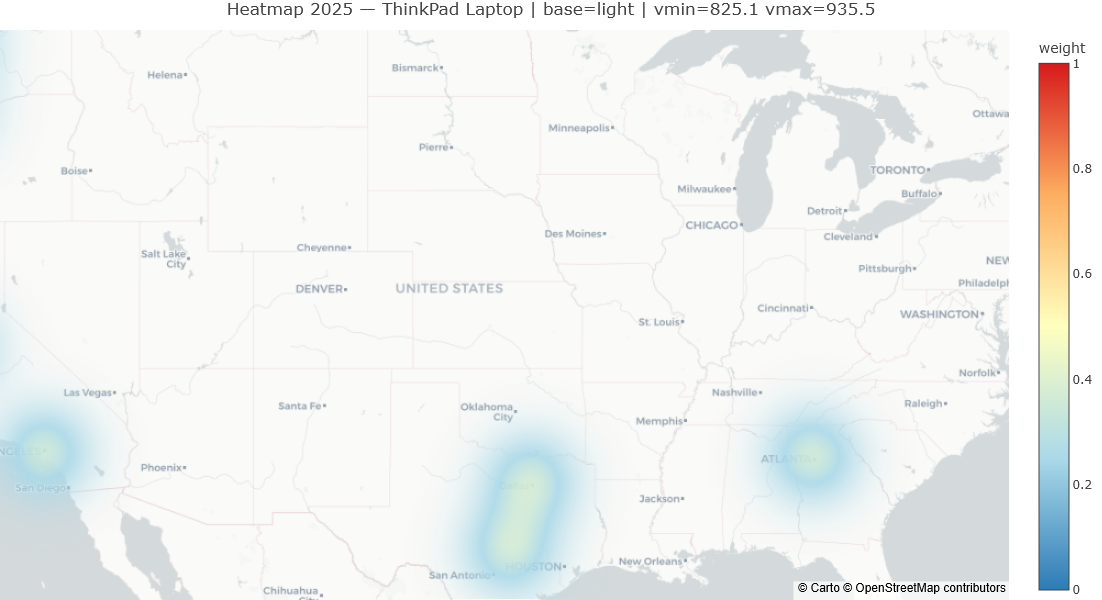

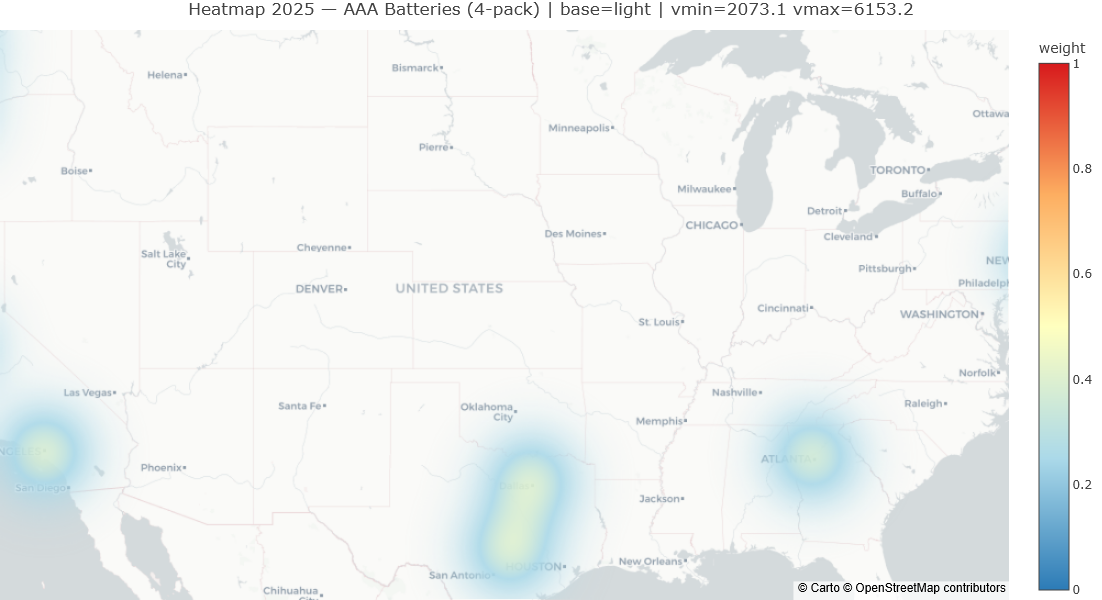

In [89]:
for prod, tab in year_tables.items():
    fig = density_map_bw(prod, tab, geo, mode="robust", base="light", gamma=0.2, radius=100)
    if fig: fig.show()


# ANALYSE TEMPORELLE - DATASET PREDIT 2025

## 1) Construire la table 2025 (mensuelle, par ville et produit)

In [99]:
import pandas as pd
import numpy as np

# predictions_2025 = {product: df[Product, city_state, period, yhat]}
ts25 = []
for prod, dfp in predictions_2025.items():
    tmp = dfp.rename(columns={"yhat":"demand"}).copy()
    tmp["period"] = pd.to_datetime(tmp["period"])
    tmp["month"] = tmp["period"].dt.month
    ts25.append(tmp[["Product","city_state","period","month","demand"]])
ts25 = pd.concat(ts25, ignore_index=True).sort_values(["Product","city_state","period"])
ts25.head(10)

,Product,city_state,period,month,demand
120,AAA Batteries (4-pack),Atlanta (GA),2025-01-01,1,436.19
121,AAA Batteries (4-pack),Atlanta (GA),2025-02-01,2,447.91
122,AAA Batteries (4-pack),Atlanta (GA),2025-03-01,3,387.33
123,AAA Batteries (4-pack),Atlanta (GA),2025-04-01,4,385.23
124,AAA Batteries (4-pack),Atlanta (GA),2025-05-01,5,377.12
125,AAA Batteries (4-pack),Atlanta (GA),2025-06-01,6,286.33
126,AAA Batteries (4-pack),Atlanta (GA),2025-07-01,7,294.76
127,AAA Batteries (4-pack),Atlanta (GA),2025-08-01,8,274.13
128,AAA Batteries (4-pack),Atlanta (GA),2025-09-01,9,253.58
129,AAA Batteries (4-pack),Atlanta (GA),2025-10-01,10,396.16


## 2) Saisonnalité globale 2025 par produit (courbe mensuelle)

In [100]:
# TABLE
glob25 = (ts25.groupby(["Product","month"])["demand"].sum()
               .reset_index()
               .sort_values(["Product","month"]))
display(glob25.head(24))  # 12 mois × 2 produits -> aperçu

,Product,month,demand
0,AAA Batteries (4-pack),1,4137.280000
1,AAA Batteries (4-pack),2,4253.480000
2,AAA Batteries (4-pack),3,3737.860000
3,AAA Batteries (4-pack),4,3734.690000
4,AAA Batteries (4-pack),5,3653.730000
5,AAA Batteries (4-pack),6,2900.500000
6,AAA Batteries (4-pack),7,3010.660000
7,AAA Batteries (4-pack),8,2788.900000
8,AAA Batteries (4-pack),9,2734.230000
9,AAA Batteries (4-pack),10,3970.070000


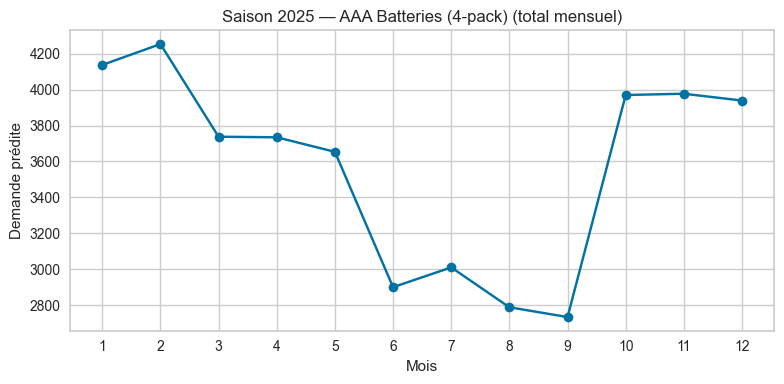

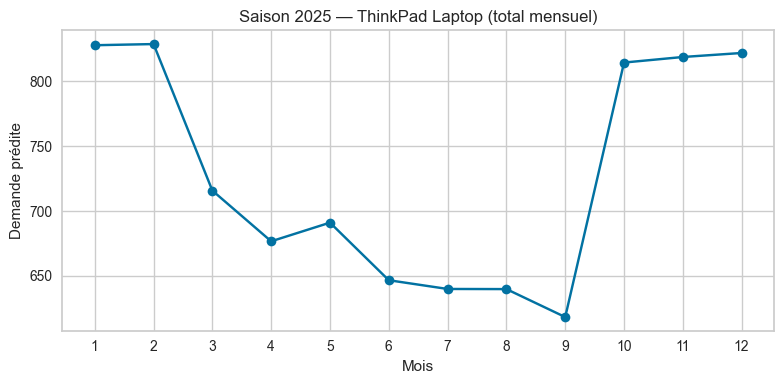

In [102]:
# PLOT
import matplotlib.pyplot as plt
for prod, g in glob25.groupby("Product"):
    m = g.set_index("month")["demand"].reindex(range(1,13), fill_value=0)
    plt.figure(figsize=(8,4))
    plt.plot(m.index, m.values, marker="o")
    plt.xticks(range(1,13))
    plt.title(f"Saison 2025 — {prod} (total mensuel)")
    plt.xlabel("Mois"); plt.ylabel("Demande prédite")
    plt.tight_layout(); plt.show()

## 3a) Statistiques géographiques 2025 — table (pente, volatilité, moyennes)

In [103]:
from statsmodels.api import OLS, add_constant

def trend_slope_2025(s: pd.Series):
    if s.notna().sum() < 3: return np.nan
    t = np.arange(1, len(s)+1)
    X = add_constant(t)
    try:
        return float(OLS(s.values.astype(float), X).fit().params[1])
    except Exception:
        return np.nan

def volatility_2025(s: pd.Series):
    return float(np.std(s.values.astype(float)))

rows = []
for prod, gp in ts25.groupby("Product"):
    for cs, gcs in gp.groupby("city_state"):
        s = (gcs.set_index("month")["demand"].reindex(range(1,13), fill_value=0))
        rows.append({
            "Product": prod,
            "city_state": cs,
            "trend_slope": trend_slope_2025(s),
            "volatility": volatility_2025(s),
            "mean_2025": float(s.mean()),
            "sum_2025": float(s.sum())
        })
geo_stats25 = pd.DataFrame(rows)

# TABLE triée (top croissances et top volumes)
for prod in ts25["Product"].unique():
    sub = geo_stats25[geo_stats25["Product"]==prod].copy()
    top_trend = sub.sort_values("trend_slope", ascending=False).head(10)
    top_sum   = sub.sort_values("sum_2025",   ascending=False).head(10)
    print(f"[{prod}] Top tendance (pente)"); display(top_trend)
    print(f"[{prod}] Top volume (somme 2025)"); display(top_sum)


[AAA Batteries (4-pack)] Top tendance (pente)


,Product,city_state,trend_slope,volatility,mean_2025,sum_2025
8,AAA Batteries (4-pack),San Francisco (CA),0.964965,22.518522,582.185000,6986.22
4,AAA Batteries (4-pack),Los Angeles (CA),0.377622,73.293935,427.930000,5135.16
6,AAA Batteries (4-pack),Portland (ME),-0.037028,4.742265,27.694167,332.33
9,AAA Batteries (4-pack),Seattle (WA),-5.119755,63.622256,360.562500,4326.75
3,AAA Batteries (4-pack),Dallas (TX),-5.296608,66.288690,358.475833,4301.71
0,AAA Batteries (4-pack),Atlanta (GA),-5.304091,64.447743,363.285833,4359.43
1,AAA Batteries (4-pack),Austin (TX),-5.436189,64.704557,363.892500,4366.71
7,AAA Batteries (4-pack),Portland (OR),-5.463357,64.658710,363.800000,4365.60
2,AAA Batteries (4-pack),Boston (MA),-5.520594,60.694902,350.050833,4200.61
5,AAA Batteries (4-pack),New York City (NY),-5.979930,66.377376,371.918333,4463.02


[AAA Batteries (4-pack)] Top volume (somme 2025)


,Product,city_state,trend_slope,volatility,mean_2025,sum_2025
8,AAA Batteries (4-pack),San Francisco (CA),0.964965,22.518522,582.185000,6986.22
4,AAA Batteries (4-pack),Los Angeles (CA),0.377622,73.293935,427.930000,5135.16
5,AAA Batteries (4-pack),New York City (NY),-5.979930,66.377376,371.918333,4463.02
1,AAA Batteries (4-pack),Austin (TX),-5.436189,64.704557,363.892500,4366.71
7,AAA Batteries (4-pack),Portland (OR),-5.463357,64.658710,363.800000,4365.60
0,AAA Batteries (4-pack),Atlanta (GA),-5.304091,64.447743,363.285833,4359.43
9,AAA Batteries (4-pack),Seattle (WA),-5.119755,63.622256,360.562500,4326.75
3,AAA Batteries (4-pack),Dallas (TX),-5.296608,66.288690,358.475833,4301.71
2,AAA Batteries (4-pack),Boston (MA),-5.520594,60.694902,350.050833,4200.61
6,AAA Batteries (4-pack),Portland (ME),-0.037028,4.742265,27.694167,332.33


[ThinkPad Laptop] Top tendance (pente)


,Product,city_state,trend_slope,volatility,mean_2025,sum_2025
18,ThinkPad Laptop,San Francisco (CA),0.437778,9.308595,81.655924,979.871094
10,ThinkPad Laptop,Atlanta (GA),0.069774,8.475434,73.431394,881.176733
14,ThinkPad Laptop,Los Angeles (CA),0.061100,8.307599,72.904498,874.853975
13,ThinkPad Laptop,Dallas (TX),0.005450,8.582421,72.512503,870.150042
11,ThinkPad Laptop,Austin (TX),0.001878,8.513796,72.451691,869.420290
16,ThinkPad Laptop,Portland (ME),0.001878,8.513796,72.451691,869.420290
19,ThinkPad Laptop,Seattle (WA),0.001878,8.513796,72.451691,869.420290
17,ThinkPad Laptop,Portland (OR),-0.012268,8.545949,72.384260,868.611123
12,ThinkPad Laptop,Boston (MA),-0.078796,8.585090,71.869281,862.431378
15,ThinkPad Laptop,New York City (NY),-0.198442,6.631236,66.211954,794.543447


[ThinkPad Laptop] Top volume (somme 2025)


,Product,city_state,trend_slope,volatility,mean_2025,sum_2025
18,ThinkPad Laptop,San Francisco (CA),0.437778,9.308595,81.655924,979.871094
10,ThinkPad Laptop,Atlanta (GA),0.069774,8.475434,73.431394,881.176733
14,ThinkPad Laptop,Los Angeles (CA),0.061100,8.307599,72.904498,874.853975
13,ThinkPad Laptop,Dallas (TX),0.005450,8.582421,72.512503,870.150042
11,ThinkPad Laptop,Austin (TX),0.001878,8.513796,72.451691,869.420290
16,ThinkPad Laptop,Portland (ME),0.001878,8.513796,72.451691,869.420290
19,ThinkPad Laptop,Seattle (WA),0.001878,8.513796,72.451691,869.420290
17,ThinkPad Laptop,Portland (OR),-0.012268,8.545949,72.384260,868.611123
12,ThinkPad Laptop,Boston (MA),-0.078796,8.585090,71.869281,862.431378
15,ThinkPad Laptop,New York City (NY),-0.198442,6.631236,66.211954,794.543447


## 3b) Optionnel — courbe par ville la plus “tendancielle” (plot)

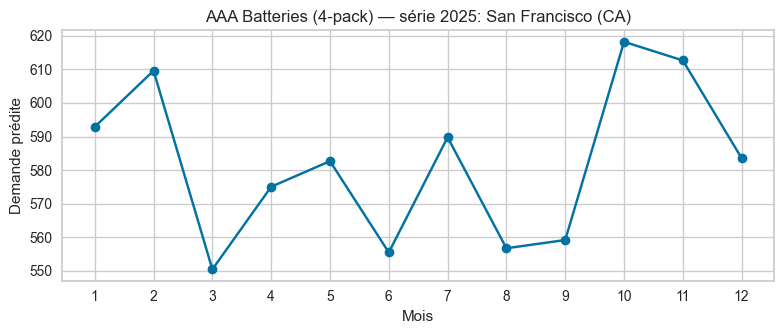

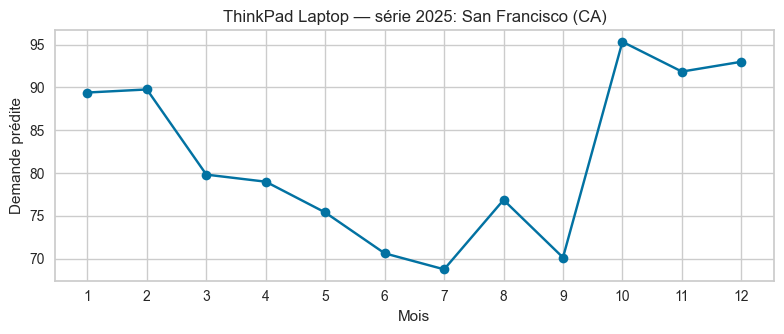

In [104]:
for prod in ts25["Product"].unique():
    sub = geo_stats25[geo_stats25["Product"]==prod].sort_values("trend_slope", ascending=False)
    if sub.empty: 
        continue
    best_city = sub.iloc[0]["city_state"]
    s = (ts25[(ts25["Product"]==prod)&(ts25["city_state"]==best_city)]
            .set_index("month")["demand"].reindex(range(1,13), fill_value=0))
    import matplotlib.pyplot as plt
    plt.figure(figsize=(8,3.5))
    plt.plot(s.index, s.values, marker="o")
    plt.xticks(range(1,13)); plt.title(f"{prod} — série 2025: {best_city}")
    plt.xlabel("Mois"); plt.ylabel("Demande prédite")
    plt.tight_layout(); plt.show()


## 4) Profil saisonnier par ville (matrice) — table puis heatmap

month,1,2,3,4,5,6,7,8,9,10,11,12
city_state,,,,,,,,,,,,
Atlanta (GA),436.19,447.91,387.33,385.23,377.12,286.33,294.76,274.13,253.58,396.16,409.15,411.54
Austin (TX),437.55,447.91,389.01,386.91,379.26,286.22,294.44,274.57,253.69,396.46,409.15,411.54
Boston (MA),418.53,433.81,378.74,373.38,357.62,275.80,287.93,266.53,247.26,381.15,387.18,392.68
Dallas (TX),433.24,446.48,383.70,378.27,371.40,275.73,286.96,269.62,247.47,395.26,406.53,407.05
Los Angeles (CA),481.93,496.47,441.26,435.61,410.73,322.59,330.16,311.49,389.86,542.51,505.22,467.33
New York City (NY),444.58,453.60,399.12,401.22,396.80,296.84,302.88,268.44,260.77,421.18,402.05,415.54
Portland (ME),24.50,27.84,33.20,29.53,23.29,31.60,34.18,20.41,18.72,28.79,31.26,29.01
Portland (OR),437.55,447.91,389.01,386.91,379.26,286.22,294.44,274.57,253.69,395.35,409.15,411.54
San Francisco (CA),592.87,609.56,550.49,575.05,582.67,555.52,589.76,556.76,559.21,618.17,612.62,583.54


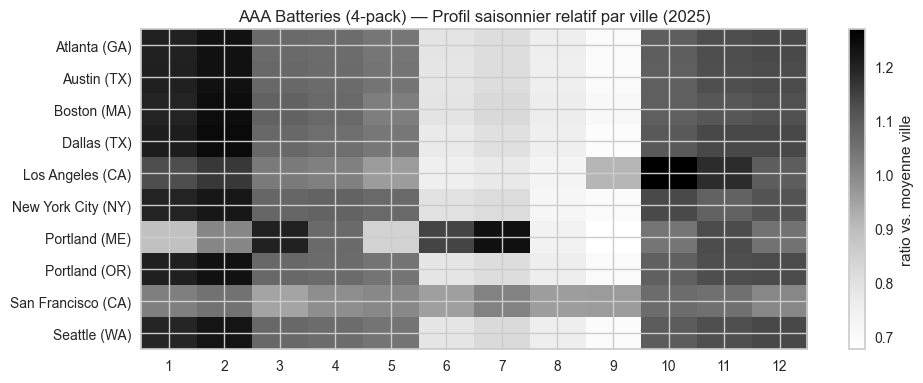

month,1,2,3,4,5,6,7,8,9,10,11,12
city_state,,,,,,,,,,,,
Atlanta (GA),83.177470,84.103629,72.552090,66.901539,68.626248,65.660046,65.063178,64.342167,62.668688,82.210614,82.868942,83.002123
Austin (TX),83.111073,82.848660,71.297121,65.646569,69.485894,64.405077,63.808208,63.087197,61.413719,80.955645,81.613972,81.747154
Boston (MA),82.362637,83.028766,70.413445,69.266500,66.487602,63.076288,62.991111,62.203521,60.530043,80.207209,80.865536,80.998718
Dallas (TX),83.257024,82.994610,71.297121,65.646569,69.485894,64.405077,63.808208,63.087197,61.413719,81.101595,81.759923,81.893104
Los Angeles (CA),82.443843,83.370002,72.172858,66.522307,68.247016,65.280814,64.683946,63.962935,62.289456,81.476987,82.135315,82.268496
New York City (NY),74.720128,74.054300,64.335595,66.787807,64.900738,60.031205,59.434336,57.326683,55.881870,70.576546,72.809378,73.684861
Portland (ME),83.111073,82.848660,71.297121,65.646569,69.485894,64.405077,63.808208,63.087197,61.413719,80.955645,81.613972,81.747154
Portland (OR),83.111073,82.848660,71.297121,65.646569,69.485894,64.405077,63.808208,62.817475,61.143997,80.685923,81.613972,81.747154
San Francisco (CA),89.403536,89.763397,79.811089,78.984492,75.388350,70.615954,68.744053,76.853348,70.125943,95.332074,91.850285,92.998571


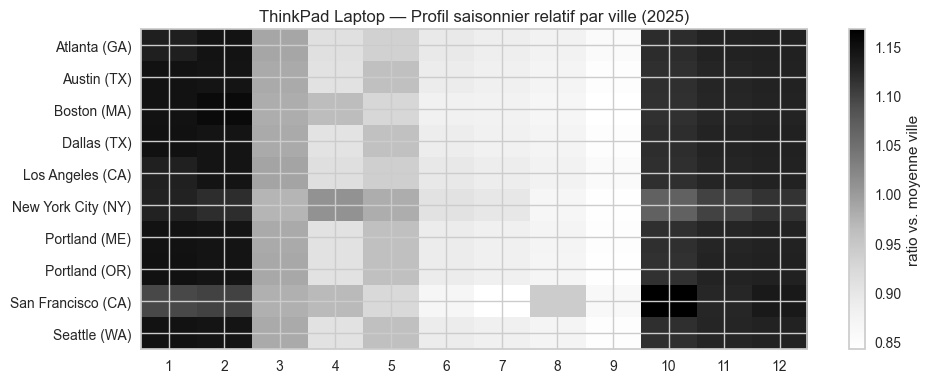

In [107]:
# TABLE (aperçu des 15 premières villes)
for prod, g in ts25.groupby("Product"):
    P = g.pivot_table(index="city_state", columns="month", values="demand", aggfunc="sum").fillna(0)
    display(P.head(15))

    # HEATMAP relative (ratio vs moyenne ville) pour comparer les formes
    denom = P.mean(axis=1).replace(0, np.nan)
    Pn = P.div(denom, axis=0).fillna(0)

    import matplotlib.pyplot as plt
    fig, ax = plt.subplots(figsize=(10, max(4, 0.22*len(Pn))))
    im = ax.imshow(Pn.values, aspect="auto")
    ax.set_yticks(range(len(Pn.index))); ax.set_yticklabels(Pn.index)
    ax.set_xticks(range(12)); ax.set_xticklabels(range(1,13))
    ax.set_title(f"{prod} — Profil saisonnier relatif par ville (2025)")
    plt.colorbar(im, ax=ax, label="ratio vs. moyenne ville")
    plt.tight_layout(); plt.show()


## 5) Export csv

In [109]:
# Export CSV sans to_csv (compatible vieux pandas)
import csv
from pathlib import Path

out = Path("../outputs")
out.mkdir(parents=True, exist_ok=True)

def save_csv_compat(df, path: Path):
    # reset index, noms simples, écriture via csv.writer
    tmp = df.reset_index(drop=True).copy()
    tmp.columns = [str(c) for c in tmp.columns]
    with open(path, "w", newline="", encoding="utf-8") as f:
        w = csv.writer(f)
        w.writerow(tmp.columns.tolist())
        for row in tmp.itertuples(index=False, name=None):
            w.writerow(row)

# 1) Séries mensuelles globales (glob25)
save_csv_compat(glob25, out / "timeseries_2025_global.csv")

# 2) Statistiques géographiques (geo_stats25)
save_csv_compat(geo_stats25, out / "geo_trend_volatility_2025.csv")

# 3) Matrices mois×ville par produit
for prod, g in ts25.groupby("Product"):
    P = g.pivot_table(index="city_state", columns="month", values="demand", aggfunc="sum").fillna(0)
    P = P.reset_index()                       # 'city_state' redevient colonne
    P.columns = [str(c) for c in P.columns]   # noms de colonnes en str
    fname = f"city_month_matrix_2025_{prod.replace(' ','_').replace('/','_')}.csv"
    save_csv_compat(P, out / fname)